# 数据观察和预处理

我们的数据放在 `BUPT-ML-FinalProject\release\data` 中，其中 `train.csv` 为训练集，`test.csv` 为测试集，`sample.csv` 为提交样例

## 数据观察

1. 直观上看，数据量很小，`train.csv` 和 `test.csv` 分别只有 981 和 979 条样本
2. 训练集的格式为 `sentiment,text`；测试集的格式为 `id,text`
3. 官方没有给 `val.csv`，这意味着我们需要按比例随机划分出验证集
4. 训练集中情感 1-5 的比例并不均衡，直观上大致符合中性情感最多，极端情感较少的规律，需要进一步根据统计情况分析
5. 数据中包含一些需要清洗掉的部分，比如
    - url 链接
    - `@` 引导的用户名
    - `""` 双引号
    - `Ì¢‰âÂ‰ã¢` 等乱码
    - `&amp;` 在 HTML 中表示 `&`，考虑暂时替换成单词 `and`（或许可能还有其它 HTML 编码）
    - `#xxx` 表示话题，包含有信息，不能直接删除，只能删掉符号

## 基本数据清洗

In [3]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
import numpy as np

In [4]:
cols_train = ['sentiment','text']
cols_test = ['id','text']
df_train_small = pd.read_csv('./data/release/train.csv', header=0)
df_test_small = pd.read_csv('./data/release/test.csv', header=0)
df_origin = pd.read_csv('./data/release/origin.csv', header=0)
df_origin = df_origin[['sentiment', 'text']]

In [5]:
def data_cleaning(text):
    text = re.sub(r'https?://[A-Za-z0-9./]+', '', str(text))  # url
    text = text.replace('Ì¢‰âÂ‰ã¢', ' ') # 一种特殊的乱码，基本出现在 we re、it s 这种的中间，替换为空格
    text = re.sub(r'[^a-z_A-Z0-9-\.!@#\$%\\\^&\*\)\(\+=\{\}\[\]\/\"\,\'<>~\·`\?:;|\s]', '', text)  # 非字母、数字、符号的其他乱码
    text = re.sub(r'[MR]T ?@[a-z]+', '', text) # RT @username、MT @username是 twitter 网站一种特殊标记
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)  # @username
    text = re.sub(r'[0-9]+:[0-9]+ [AP]M', '', text) # 时间戳
    text = re.sub(r'\d+', ' ', text) # 去除数字
    text = re.sub(r'R[Ee]:', '', text) # 表示回复消息的 RE
    text = text.replace(',', '').replace(r'"', '').replace('#', '').replace('&', 'and')  # , and "" and # and &
    text = BeautifulSoup(text, 'lxml').get_text()  # html编码
    text = re.sub(r'[_\-@%#\$\^\*\)\(\+=\{\}\[\]\/\"<>~`:;|]', ' ', text)  # 剩下的一些无用符号
    text = text.lower() # 转小写
    text = re.sub(r'^ +', '', text) # 开头的空格去除
    text = re.sub(r' +$', '', text) # 结尾的空格去除
    text = re.sub(r' +', ' ', text) # 多个空格替换成一个
    
    return text

In [6]:
# 小数据集
df_train_small['text'] = df_train_small['text'].map(data_cleaning)
df_test_small['text'] = df_test_small['text'].map(data_cleaning)
df_train_small.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 0 to 980
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  981 non-null    int64 
 1   text       981 non-null    object
dtypes: int64(1), object(1)
memory usage: 15.5+ KB


In [7]:
# 大数据集
df_origin = df_origin[df_origin['sentiment']!='not_relevant'] # 删除 not_relevant 行
df_origin['sentiment'] = df_origin['sentiment'].astype(np.int32) # 将 sentiment 列类型改为 int32，方便后续 split 操作
df_origin['text'] = df_origin['text'].map(data_cleaning)
df_origin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6943 entries, 0 to 7145
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  6943 non-null   int32 
 1   text       6943 non-null   object
dtypes: int32(1), object(1)
memory usage: 135.6+ KB


## 可视化

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# 忽略所有警告（比如，绘制箱型图有警告）
import warnings
warnings.filterwarnings("ignore")

### 箱型图观察异常数据

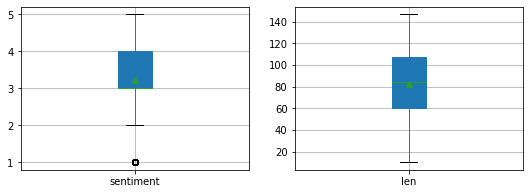

In [28]:
df_tmp = df_origin
df_tmp['len'] = df_tmp['text'].map(lambda x: len(x))
sentiments = df_tmp[['sentiment']]
lens = df_tmp[['len']]

fig = plt.figure(figsize=(9,3))
plt.subplot(1, 2, 1)
sentiments.boxplot(sym='o', patch_artist = True, meanline = False, showmeans = True, showbox = True, showfliers = True, notch = False)
plt.subplot(1, 2, 2)
lens.boxplot(sym='o', patch_artist = True, meanline = False, showmeans = True, showbox = True, showfliers = True, notch = False)
plt.show()

### 分布直方图查看 sentiment 分布和 text 长度分布

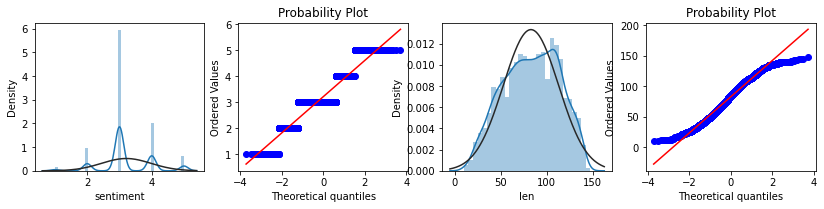

In [26]:
plt.figure(figsize=(14,6))

plt.subplot(2, 4, 1)
sns.distplot(df_tmp['sentiment'], fit=stats.norm)

plt.subplot(2, 4, 2)
stats.probplot(df_tmp['sentiment'], plot=plt)

plt.subplot(2, 4, 3)
sns.distplot(df_tmp['len'], fit=stats.norm)

plt.subplot(2, 4, 4)
stats.probplot(df_tmp['len'], plot=plt)

plt.show()

## 数据集划分

In [11]:
def split_small(val_ratio=0.2, split_seed=1234):
    df_test_small.to_csv('./data/preprocessed/small/test.csv', index=False)
    
    dir_train = './data/preprocessed/small/train.csv'
    dir_val = './data/preprocessed/small/dev.csv'

    headers = pd.DataFrame(columns=cols_train)
    headers.to_csv(dir_train, index=False)
    headers.to_csv(dir_val, index=False)
    
    for i in range(1, 6):
        df_train_split, df_val_split = train_test_split(df_train_small[df_train_small['sentiment']==i], test_size=val_ratio, random_state=split_seed)
        df_train_split.to_csv(dir_train, index=False, mode='a', header=None)
        df_val_split.to_csv(dir_val, index=False, mode='a', header=None)

In [12]:
def split_big_with_test(first_ratio=0.2, second_ratio=0.5, split_seed=1234):
    dir_train = './data/preprocessed/big/train.csv'
    dir_val = './data/preprocessed/big/dev.csv'
    dir_test = './data/preprocessed/big/test.csv'

    headers = pd.DataFrame(columns=cols_train)
    headers.to_csv(dir_train, index=False)
    headers.to_csv(dir_val, index=False)
    headers.to_csv(dir_test, index=False)

    for i in range(1, 6):
        # print(df_origin.head())
        # print(df_origin.info())
        df_train_split, df_other_split = train_test_split(df_origin[df_origin['sentiment']==i], test_size=first_ratio, random_state=split_seed)
        df_train_split.to_csv(dir_train, index=False, mode='a', header=None)
        
        df_val_split, df_test_split = train_test_split(df_other_split[df_other_split['sentiment']==i], test_size=second_ratio, random_state=split_seed)
        df_val_split.to_csv(dir_val, index=False, mode='a', header=None)
        df_test_split.to_csv(dir_test, index=False, mode='a', header=None)

In [13]:
def split_big_no_test(sample_num=6800, val_ratio=0.1, split_seed=1234):
    dir_train = './data/preprocessed/big/train.csv'
    dir_val = './data/preprocessed/big/dev.csv'

    headers = pd.DataFrame(columns=cols_train)
    headers.to_csv(dir_train, index=False)
    headers.to_csv(dir_val, index=False)

    df_sample = df_origin.sample(n=sample_num, axis=0, random_state=split_seed)

    for i in range(1, 6):
        df_train_split, df_val_split = train_test_split(df_sample[df_sample['sentiment']==i], test_size=val_ratio, random_state=split_seed)
        df_train_split.to_csv(dir_train, index=False, mode='a', header=None)
        df_val_split.to_csv(dir_val, index=False, mode='a', header=None)
    

In [14]:
split_small()
# split_big_with_test()
split_big_no_test()